In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
# using BenchmarkTools
import ProgressMeter
using LinearAlgebra

In [2]:
# Multivariate update
ReactiveMP.@rule NormalMixture{N}(:out, Marginalisation) (q_switch::Any, q_m::NTuple{N,  MultivariateNormalDistributionsFamily}, q_p::NTuple{N, Wishart }) where { N } = begin
    πs = probvec(q_switch)
    d  = ndims(first(q_m))
    w  = mapreduce(x -> x[1]*mean(x[2]), +, zip(πs, q_p))
    xi = mapreduce(x -> x[1]*mean(x[2])*mean(x[3]), +, zip(πs, q_p, q_m))
    return MvNormalWeightedMeanPrecision(xi, w)
end

In [170]:
using Optim

function my_optimizer(::Type{ Univariate }, ::Type{ Continuous }, constraint::PointMassFormConstraint, distribution)
    target = let distribution = distribution 
        (x) -> -logpdf(distribution, x[1])
    end
    support = Distributions.support(distribution)
    result = if isinf(Distributions.minimum(support)) && isinf(Distributions.maximum(support))
        optimize(target, call_starting_point(constraint, distribution), LBFGS(), Optim.Options(iterations = 5))
    else
        lb = [ Distributions.minimum(support) ]
        rb = [ Distributions.maximum(support) ]
        optimize(target, lb, rb, call_starting_point(constraint, distribution), Fminbox(GradientDescent()), Optim.Options(iterations = 5))
    end
    return PointMass(Optim.minimizer(result)[1])
end

my_optimizer (generic function with 1 method)

## Switching AR

In [171]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                     priors_as, priors_bs,
                                                                     priors_ms, priors_ws)

    n = length(outputs)
    A ~ MatrixDirichlet(ones(nmixtures, nmixtures))

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    as = randomvar(nmixtures, prod_constraint = ProdGeneric(), form_constraint = PointMassFormConstraint(optimizer = my_optimizer, starting_point = (_, _, _, dist) -> [ mean(ReactiveMP.getleft(dist)) ]))
    bs = randomvar(nmixtures)
    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
        ms[i] ~ MvNormalMeanCovariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ Wishart(priors_ws[i][1], priors_ws[i][2])
    end

    z  = randomvar(nbuckets)
    γ  = randomvar(nbuckets)
    θ  = randomvar(nbuckets)
    dp = randomvar(n)
    x  = datavar(Vector{Float64}, n)
    y  = datavar(Float64, n)

    tas = tuple(as...)
    tbs = tuple(bs...)
    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ GammaMixture(z[i], tas, tbs)
        θ[i] ~ GaussianMixture(z[i], tms, tws) where { q = MeanField() }
        z_prev = z[i]
    end
    
    k = div(n + ARorder, nbuckets)

    for i in 1:n
        r     = div(i - 1, k) + 1
        dp[i] ~ dot(x[i], θ[r])
        y[i]  ~ NormalMeanPrecision(dp[i], γ[r]) 
    end

    scheduler = schedule_updates(as, bs, ms, ws)
#     scheduler = schedule_updates(ms, ws, as, bs, z, θ, γ, A)

    return scheduler, z, A, as, bs, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [172]:
function inference_ar(inputs, outputs, nmixtures, nbuckets, n_its, priors_as, priors_bs, priors_ms, priors_ws)
    n = length(outputs)
    ARorder = size(priors_ms[1])[1]

    model, (scheduler, z, A, as, bs, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                          priors_as, priors_bs,
                                                                          priors_ms, priors_ws, options=(limit_stack_depth=100,));
    

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mas     = keep(Vector{Marginal})
    mbs     = keep(Vector{Marginal})
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    as_sub     = subscribe!(getmarginals(as), mas)
    bs_sub     = subscribe!(getmarginals(bs), mbs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(bs), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (i, (a, b, m, w)) in enumerate(zip(as, bs, ms, ws))
        setmarginal!(a, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(b, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(m, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(w, vague(Wishart, ARorder))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end


    return map(getvalues, (mzs, mγs, mθs, mA, mas, mbs, mms, mws, fe))
end

inference_ar (generic function with 1 method)

In [173]:
ReactiveMP.release!(::Nothing) = nothing

In [174]:
# cherry picking
# seed 22
γs = [1.0, 0.1]
θs = [[0.3, 0.1], [0.1, -0.2]]

γs = [1.0, 1.0]
θs = [[-0.3, 0.5], [0.1, -0.2]]

2-element Vector{Vector{Float64}}:
 [-0.3, 0.5]
 [0.1, -0.2]

## Generate AR

In [189]:
using Random
Random.seed!(22)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions

# γs = [245.962112192862, 90.886395860746]
# θs = [[0.8731158607733491, -0.026690112026955762, -0.04367017292158071, -0.14918834993939312, 0.08651121456635708], [1.4957459225329481, -1.1455902634100235, 0.45396514413612765, -0.1759947625051197, 0.07414315761033508]]
γs = [3.0, 1.0]
θs = [[0.3, 0.1], [0.1, -0.2]]
ARorder = length(first(θs))

@assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 5000
x = 0.1*ones(ARorder)
# x = [1.0, 2.0]

n_slice_n = 500

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

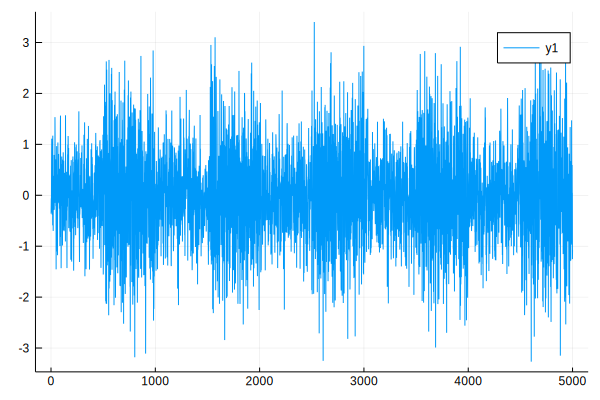

In [190]:
using Plots
plot(outputs)

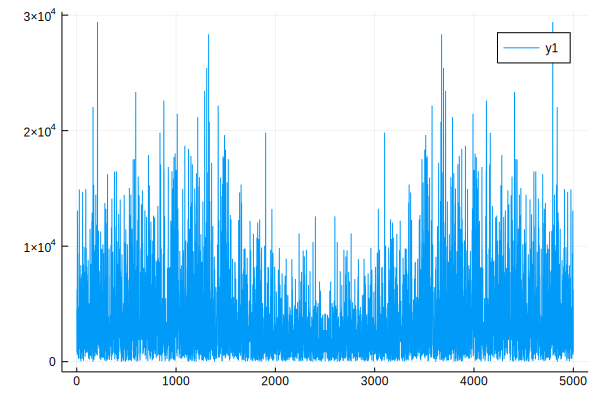

In [191]:
using FFTW
plot(abs.(fft(outputs)).^2)

In [192]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:size(inputs_, 1)]

4998-element Vector{Float64}:
 -0.36109941410515206
 -0.20842914125888648
 -0.06073521538735251
 -0.3274437153212681
  0.3943585071793553
  0.8294406936231583
  1.1118848555719332
  0.09843817916761782
 -0.03508111483342152
 -0.03555180513041796
  1.0513205495082028
 -0.38507321900686076
  0.7121031647524859
  ⋮
 -0.9741885291876691
 -0.9026524942445342
  0.35182991976180145
 -0.2547497351652493
  1.4709709265707558
  0.08787372810171848
 -0.9519646602287186
 -0.875149002822249
 -0.41986054391957073
  0.5944144735287197
 -0.3337269092860706
  0.04728212078117264

In [193]:
csep = 10.0

priors_as = map(γ -> infgamma(Float64, γ*csep), γs)
priors_bs = map(_ -> infgamma(Float64, csep), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ, 1e2*diageye(ARorder)), θs)
priors_ws = map(_ -> (ARorder, 1e4*diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))

@time mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_ar(inputs_, outputs_, nmixtures, 500, 500, priors_as, priors_bs, priors_ms, priors_ws);

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

134.404246 seconds (690.80 M allocations: 44.398 GiB, 15.31% gc time, 0.09% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:02:13


In [194]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.431118  0.0019933
 0.568882  0.998007

In [195]:
minimum(mean.(mγs[end]))

0.6278250087066098

In [196]:
mean.(mθs[end])

500-element Vector{Vector{Float64}}:
 [0.17277293129966173, -0.1044072123930275]
 [0.16958327797132322, -0.10466252652300467]
 [0.17099358080837443, -0.10482562741098947]
 [0.17393079875325237, -0.10260272469201515]
 [0.17206514312934051, -0.10343052487978424]
 [0.17155663672675955, -0.10493377200992701]
 [0.17237749496531748, -0.10459987765620737]
 [0.1710937927714255, -0.10491786976106901]
 [0.17135938196151046, -0.10638256906017607]
 [0.1759757743113033, -0.10089246447451963]
 [0.1716810773090205, -0.10553278776143715]
 [0.16950950167200046, -0.10737864906780537]
 [0.17156863512684245, -0.10497745336091849]
 ⋮
 [0.1669263200742829, -0.10810096188867105]
 [0.17061800195923743, -0.10544862048611328]
 [0.17026865464722418, -0.10768280253867574]
 [0.16973176294740622, -0.10768058592949259]
 [0.1692405783986508, -0.09870108561349603]
 [0.15968543865068147, -0.11764975204041284]
 [0.17003576119028807, -0.10677800356503078]
 [0.17077041346018873, -0.10576894392674607]
 [0.17252381273751402

In [197]:
using Plots

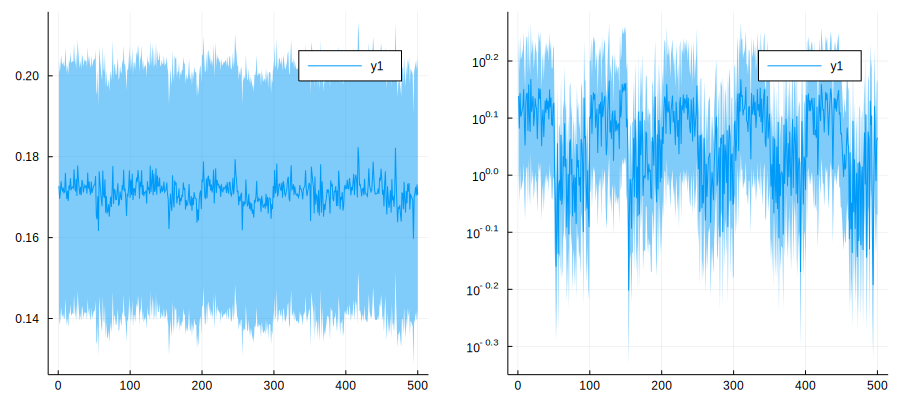

In [204]:
dim(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dim(index), ribbon = std.(mθs[end]) |> dim(index))
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10)

plot(p1, p2, size = (900, 400))

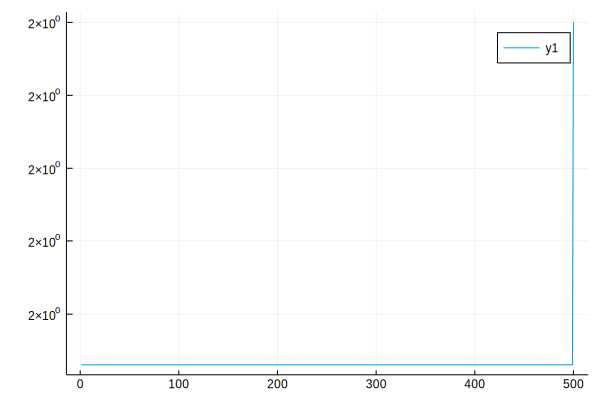

In [199]:
plot(mean.(mzs[end]))

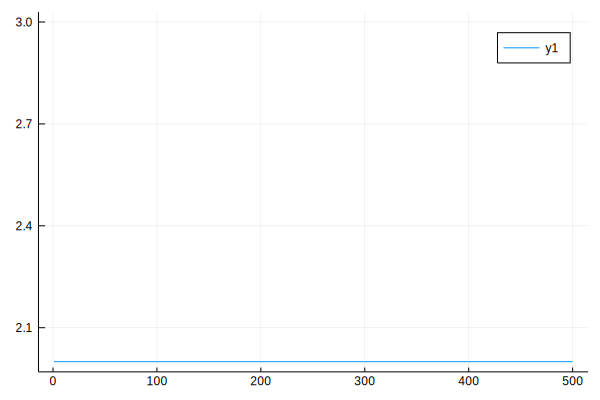

In [200]:
plot(round.(mean.(mzs[end])))

In [201]:
mean.(mzs[end])

500-element Vector{Float64}:
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 ⋮
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999990001

mfe[end - 4:end] = [6309.822259421635, 6309.818724985162, 6309.815199360637, 6309.81168250546, 6309.808174378417]


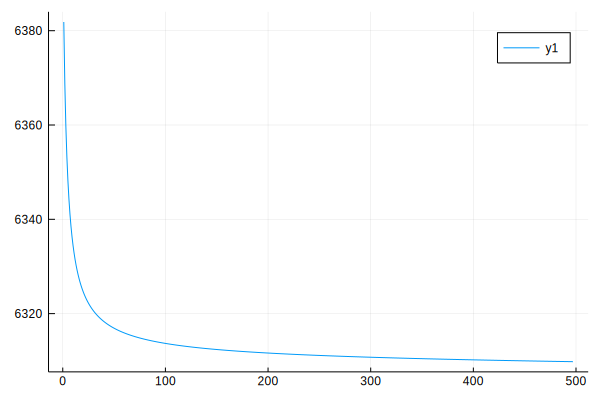

In [202]:
@show mfe[end-4:end]
plot(mfe[4:end])